# Deep Learning Project
## Convolutional Neural Networks
### Leaf Disease Segmentation

### Kaleabe Negussie
### UGR/3411/12

link to the dataset on kaggle
https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset
---
link to the preprocessed data set https://drive.google.com/drive/folders/1QQMLrzPwopphgoLRQlNAO2rWqi3fxaOP?usp=drive_link
---
**On the graphs the green line shows the accuracy while the red one shows the loss over the last 100 iterations of the training**

**The sample images are images taken from the test set and show the predicted segmentation, the true label and the original image respectively**


---


**Introduction**
---
In this project the problem that I tried to solve was related to leaf disease segmentation. The link to the dataset is the following https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset

In the model I have used UNet architecture that is composed of 4 contraction and 4 expansion blocks. Each contraction model is composed of Convolution,Relu activation,Convolution,Relu activation, Dropout and max pooling layer. I have used Inverse convolution, Relu activation, Convolution,Relu activation, Convolution and Relu activation with skip connections. After the contraction and expansion layers there is a single convolution followed by sigmoid activation that is used to change the values to be between zero and one.

In the preprocessing I have changed the size of the images both in the masks and the leaf images to be 256*256. The leaf images are represented by rgb values while the masks are represented by a single grayscale value which is then changed to have values of either 0 or 1 during preprocessing. One represents diseased areas while zero represents neutral parts of the leaf and other background parts.
The link to the preprocessing file https://github.com/kaleabe-n/Deep-learning/blob/main/DL_Proj_preprocessing.ipynb

---
The content of the notebook include
* imports
* the model definition and other helper functions
* loading images from google drive and spliting them into training and testing sets
* Learning rates which is composed of trying different learning rates(0.0001,0.001,0.1) three models with there results and graphs that show losses and accuracies between this learning rate values
* Optimizers which is composed of trying different models with different optimizers namely Adam,SGD and SGD with momuntum
* Losses is composed of trying different models with different losses namely Binary cross entropy and Mean squared error loss
* Batches trying different batch sizes for training 1,8,16 and 32 and showing the result with graph of accuracy and loss versus batch sizes
* Conclusion describe the key findings of the project
* testing the model with 16 batch size with your own image

---
link to the saved model state dict https://github.com/kaleabe-n/Deep-learning/blob/main/model.pth
* make sure that the model is in the same directory as the notebook and the shape of the image is 264*264 rgb image you can use images from the preprocessed dataset

---

I cleared most of the outputs which were displaying sample images since it was having trouble to render them on github

# imports

I have used different packages for opencv to read image files, os to access the list of files in the directory, tqdm to show progress of loops, numpy for different calculations, matplotlib to plot graphs and scikit leart for train test spliting.

In [ ]:
import cv2 as cv
import torch
import os
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from torch import optim
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# model definition and helper functions

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, optimizer, loss, lr, momuntum=0):
        super(UNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(
            self.contracting_block(in_channels, 16),
            self.contracting_block(16, 32),
            self.contracting_block(32, 64),
            self.contracting_block(64, 128),

            self.expanding_block(128, 64),
            self.expanding_block(64, 32),
            self.expanding_block(32, 16),
            self.expanding_block(16, 8),

            nn.Conv2d(8, out_channels, kernel_size=1, stride=1),

            nn.Sigmoid()
        )
        self.loss = loss
        if momuntum != 0:
            self.optimizer = optimizer(list(self.model.parameters()), lr=lr,momentum=momuntum)
        else:
            self.optimizer = optimizer(list(self.model.parameters()), lr=lr)

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return block

    def expanding_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def crop_and_concat(self, upsampled, bypass):
        c = (bypass.size()[2] - upsampled.size()[2]) // 2
        bypass = bypass[:, :, c:upsampled.size()[2] + c, c:upsampled.size()[3] + c]
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        self.output = self.model(x)
        return self.output

    def backward(self,output,y_true):
        curr_loss = self.loss(output,y_true)
        self.optimizer.zero_grad()
        curr_loss.backward()
        self.optimizer.step()
        return curr_loss

    def fit(self,batch_size,epoches,x,y):
        iterations = math.ceil(len(x)/batch_size)
        self.model.to(self.device)
        losses = []
        accuracies = []
        for epoch in tqdm(range(epoches)):
            for iter in range(iterations):
                start = iter * batch_size
                end = start + batch_size
                curr_x = torch.Tensor(np.transpose(x[start:end], (0, 3, 1, 2)))
                curr_y = torch.Tensor(np.transpose(np.expand_dims(y[start:end],axis=0),(1,0,2,3)))
                curr_x = curr_x.to(self.device)
                curr_y = curr_y.to(self.device)
                output = self.model(curr_x)
                curr_loss = self.backward(output,curr_y)
                losses.append(float(curr_loss))
                curr_acc = (output.round() == curr_y).float().mean()
                accuracies.append(curr_acc)
        return losses,accuracies


plot the accuracy and loss of training

In [ ]:
def plot_acc_and_loss(accuracies,losses):
    acc = [x.cpu() for x in accuracies]
    plt.plot(range(100),acc[-100:],"g")
    loss = [x for x in losses]
    plt.plot(range(100),loss[-100:],'r')

calculate training and testing accuracies and losses

In [ ]:
def training_and_testing_accuracy(unet_model):
    total_loss = 0
    total_accuracy = 0
    for i in tqdm(range(len(x_train))):
        curr = np.transpose(x_train[i], (2, 0, 1))
        temp = torch.Tensor(curr).to(unet_model.device)
        temp = unet_model.forward(temp)
        temp = np.array(temp.cpu().detach().numpy())
        y_true_curr = (y_train[i]>0).astype(float)
        pred = (np.transpose(temp, (1, 2, 0))>=0.5).astype(float).reshape(y_true_curr.shape)
        loss = nn.BCELoss()(torch.Tensor(pred),torch.Tensor(y_true_curr))
        total_loss += float(loss)
        total_accuracy += np.sum(pred==(y_train[i]>0).astype(float))/(256*256)

    training_loss = total_loss/len(x_train)
    training_acc = total_accuracy/len(x_train)

    total_loss = 0
    total_accuracy = 0
    for i in tqdm(range(len(x_test))):
        curr = np.transpose(x_test[i], (2, 0, 1))
        temp = torch.Tensor(curr).to(unet_model.device)
        temp = unet_model.forward(temp)
        temp = np.array(temp.cpu().detach().numpy())
        y_true_curr = (y_test[i]>0).astype(float)
        pred = (np.transpose(temp, (1, 2, 0))>=0.5).astype(float).reshape(y_true_curr.shape)
        loss = nn.BCELoss()(torch.Tensor(pred),torch.Tensor(y_true_curr))
        total_loss += float(loss)
        total_accuracy += np.sum(pred==(y_test[i]>0).astype(float))/(256*256)

    test_loss = total_loss/len(x_test)
    test_acc = total_accuracy/len(x_test)

    print()
    print("=============")
    print("training")
    print("loss",training_loss)
    print("accuracy",training_acc)
    print("++++++++++++")
    print('test')
    print("loss",test_loss)
    print('accuracy',test_acc)
    print("================")

display sample test images from test set

In [ ]:
def sample_test_images(unet_model):
    for i in range(10):
        curr = np.transpose(x_test[i], (2, 0, 1))
        temp = torch.Tensor(curr).to(unet_model.device)
        pred = unet_model.forward(temp)
        temp = np.array(pred.cpu().detach().numpy())
        pred = (np.transpose(temp, (1, 2, 0))>=0.5) * 255
        print("+++++++++++++=========================++++++++++++++")
        print("predicted image")
        cv2_imshow(pred)
        print("true label")
        cv2_imshow((y_test[i]==1)*255)
        temp = np.array(x_test[i])
        print("actual image")
        cv2_imshow(temp)
        print("++++++++++++===========================++++++++++++++")

# loading images from file(from google drive) and split them into testing and training

In [49]:
def image_and_mask_loader(images_path,masks_path):
    _,_,image_paths = next(os.walk(images_path))
    images = []
    masks = []
    for path in tqdm(image_paths):
        img_path = os.path.join(images_path,path)
        mask_path = os.path.join(masks_path,path)
        images.append(cv.imread(img_path))
        masks.append(cv.imread(mask_path,0)>0)
    return np.array(images),np.array(masks)

In [50]:
images,masks = image_and_mask_loader("drive/MyDrive/leaf data/preprocessed/images/","drive/MyDrive/leaf data/preprocessed/masks/")
x_train,x_test,y_train,y_test = train_test_split(images,masks,test_size=0.2)

100%|██████████| 588/588 [00:08<00:00, 70.44it/s]


# learning rates

## 0.0001 lr

In [ ]:

unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.0001)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


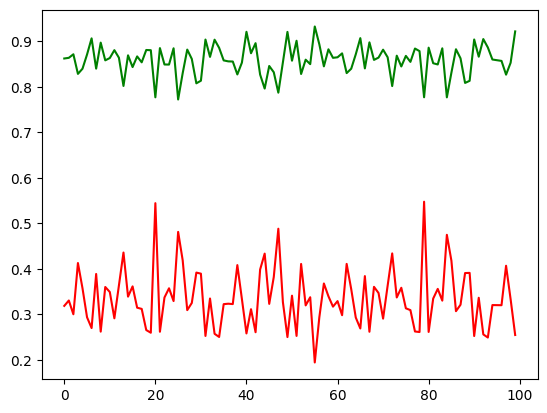

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:01<00:00, 105.90it/s]


training
loss 13.82171630859375
accuracy 0.8617828369140625
++++++++++++
test
loss 14.835202491889566
accuracy 0.8516479750811043


In [ ]:
sample_test_images(unet_model)

## 0.01 lr

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.01)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


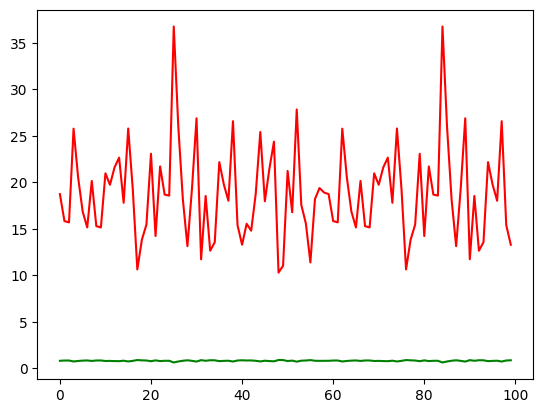

In [ ]:
plot_acc_and_loss(accuracies,losses)

As shown in the graph above the model was not converging to the correct values. The model kept converging to small similar values for all pixels that did not represent a correct segmentation and the accuracy(green) was close to zero.

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 147.63it/s]


training
loss 18.687776606133642
accuracy 0.8131222339386636
++++++++++++
test
loss 19.77466647907839
accuracy 0.8022533352092162


In [ ]:
sample_test_images(unet_model)

## 0.001 lr

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


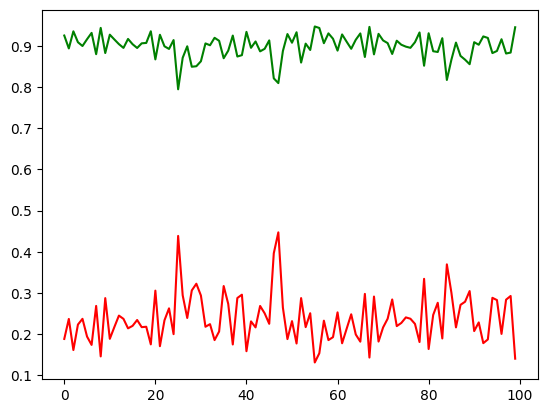

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 151.18it/s]


training
loss 9.56102411797706
accuracy 0.9043897588202294
++++++++++++
test
loss 12.553935939982786
accuracy 0.8744606406001721


+++++++++++++=========================++++++++++++++
predicted image


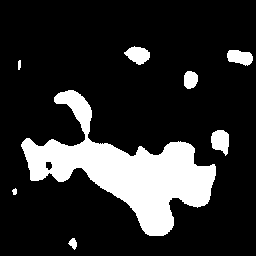

true label


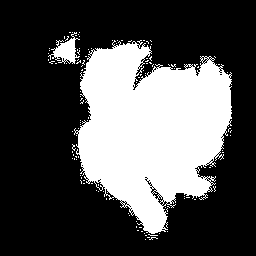

actual image


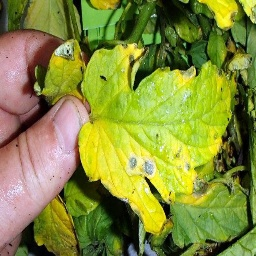

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


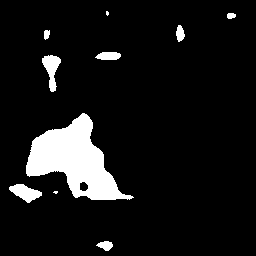

true label


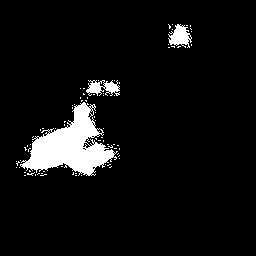

actual image


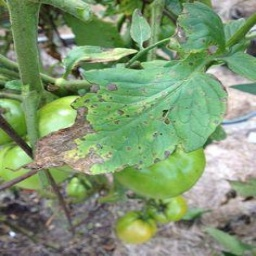

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


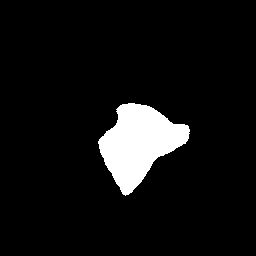

true label


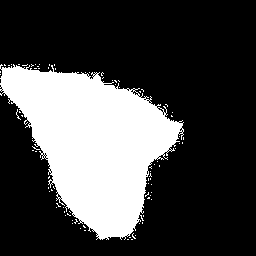

actual image


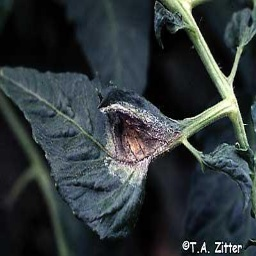

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


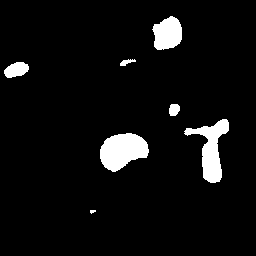

true label


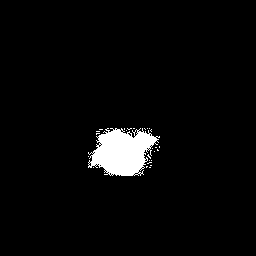

actual image


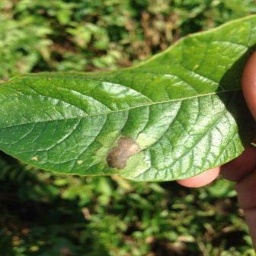

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


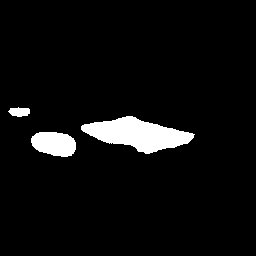

true label


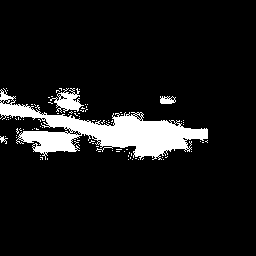

actual image


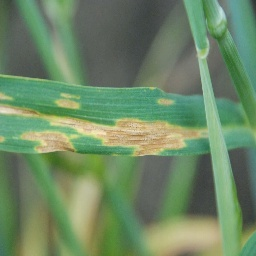

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


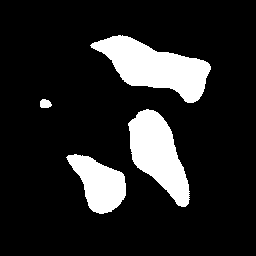

true label


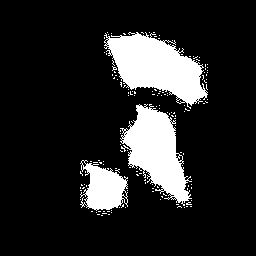

actual image


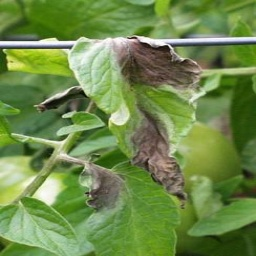

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


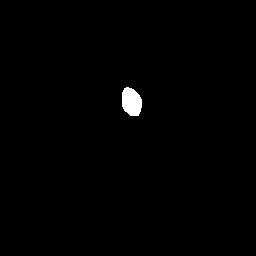

true label


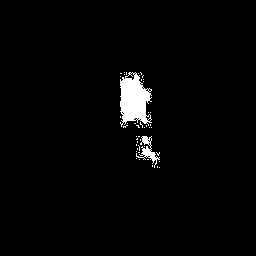

actual image


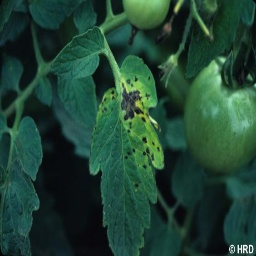

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


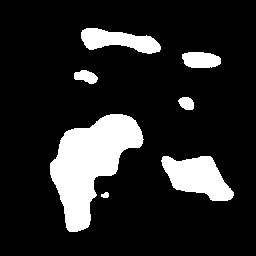

true label


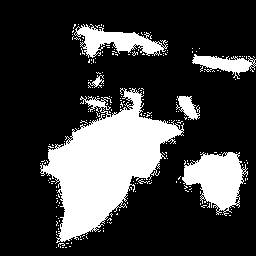

actual image


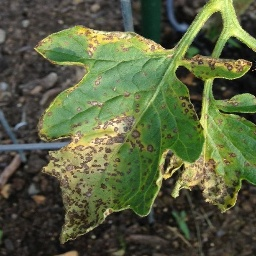

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


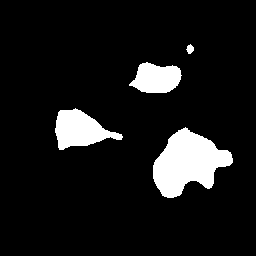

true label


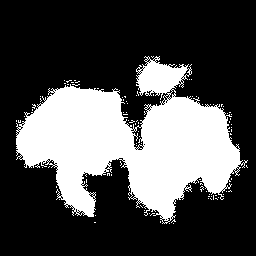

actual image


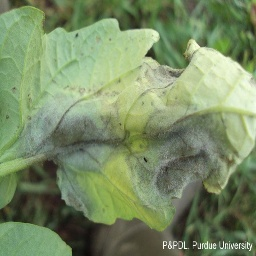

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


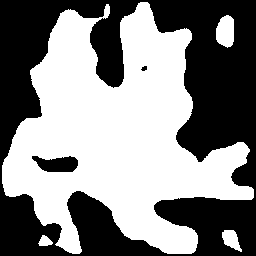

true label


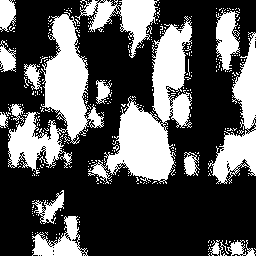

actual image


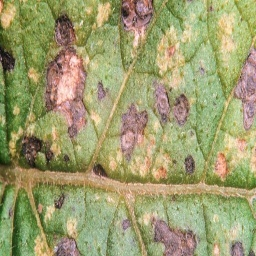

++++++++++++===========================++++++++++++++


In [ ]:
sample_test_images(unet_model)

## accuracies across learning rates

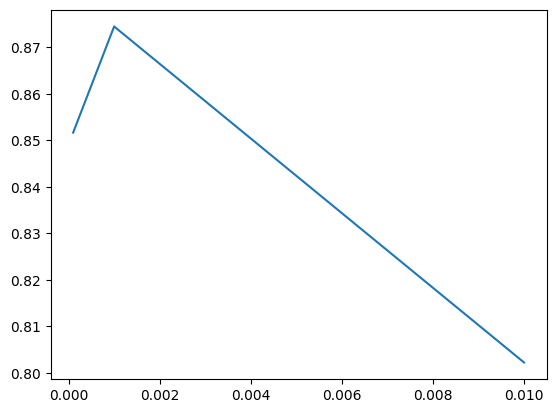

In [ ]:
lrs = [0.0001,0.001,0.01]
accuracies = [0.8516479750811043,0.8744606406001721,0.8022533352092162]
plt.plot(lrs,accuracies)

## Losses across learning rates

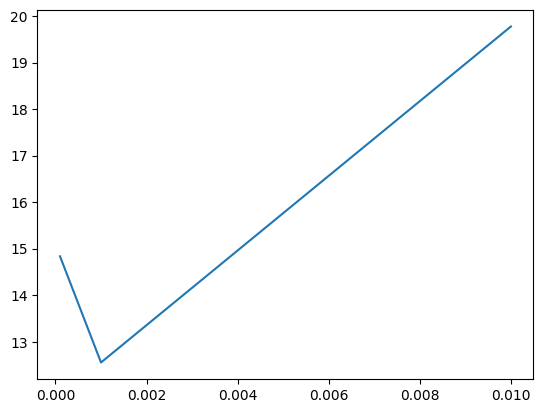

In [ ]:
lrs = [0.0001,0.001,0.01]
losses = [14.835202491889566,12.553935939982786,19.77466647907839]
plt.plot(lrs,losses)

# optimizers

## Adam

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:19<00:00,  2.79s/it]


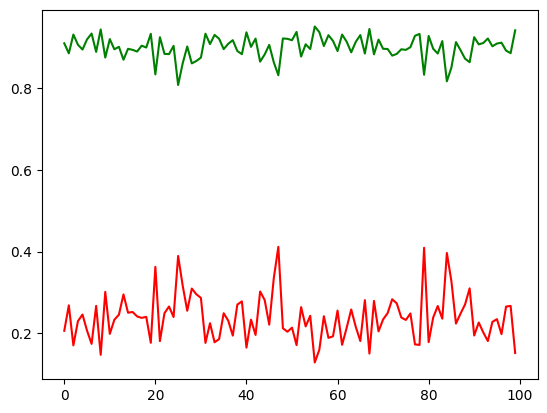

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 152.53it/s]


training
loss 9.79222074468085
accuracy 0.9020777925531915
++++++++++++
test
loss 12.880228333554026
accuracy 0.8711977166644598


+++++++++++++=========================++++++++++++++
predicted image


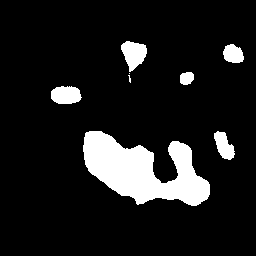

true label


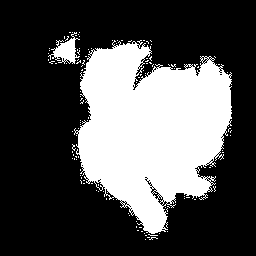

actual image


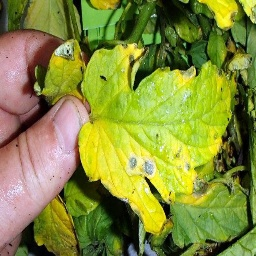

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


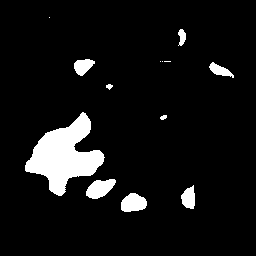

true label


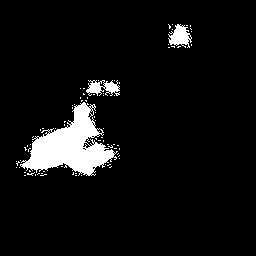

actual image


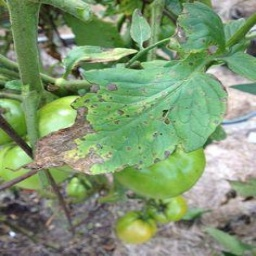

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


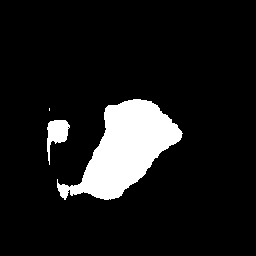

true label


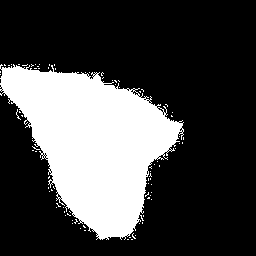

actual image


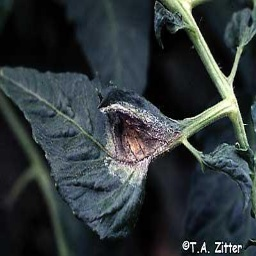

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


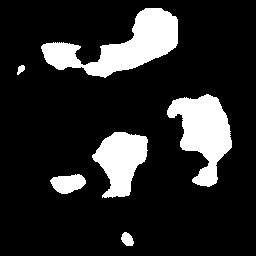

true label


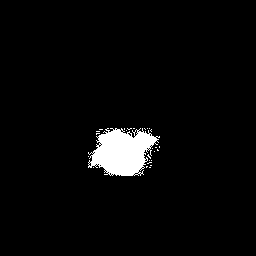

actual image


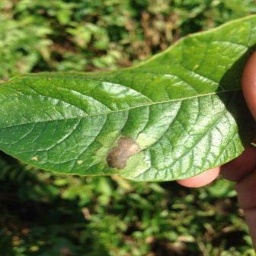

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


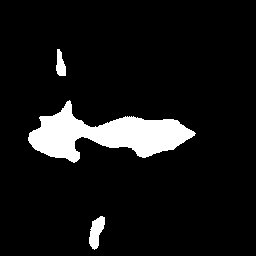

true label


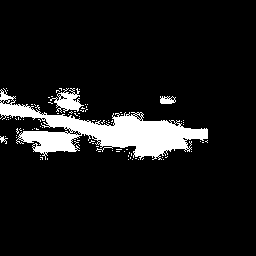

actual image


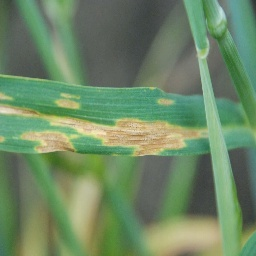

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


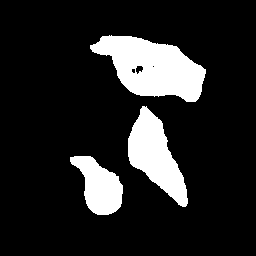

true label


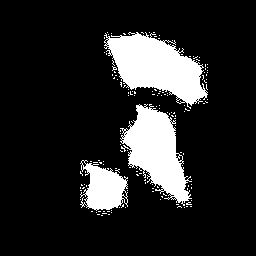

actual image


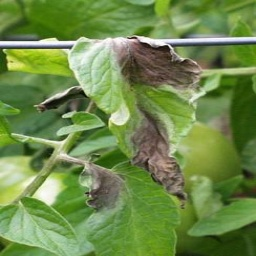

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


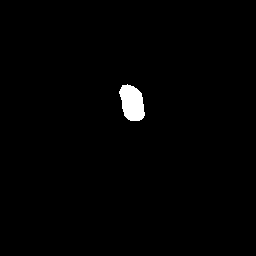

true label


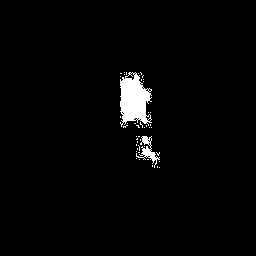

actual image


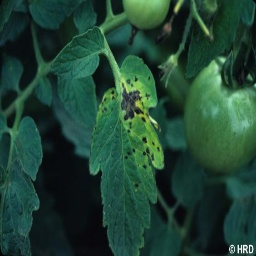

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


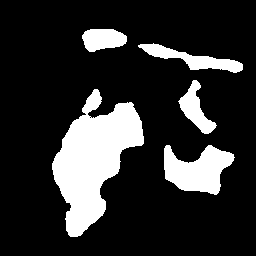

true label


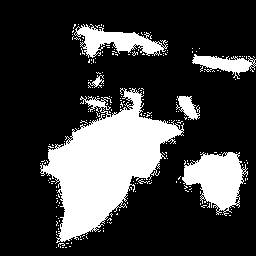

actual image


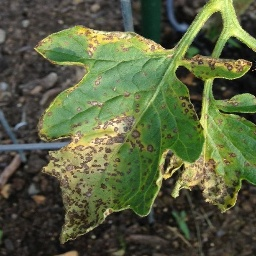

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


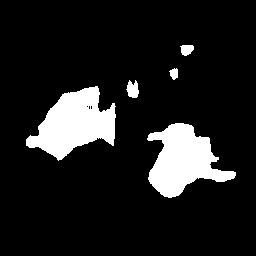

true label


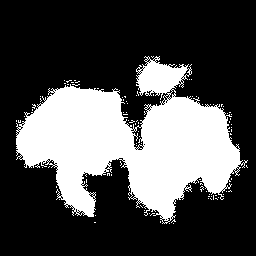

actual image


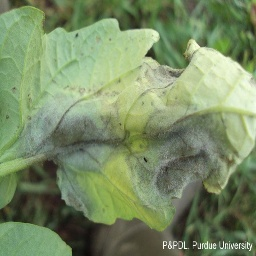

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


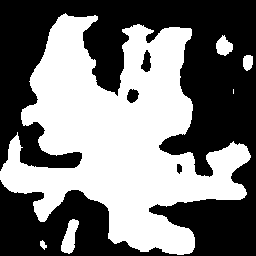

true label


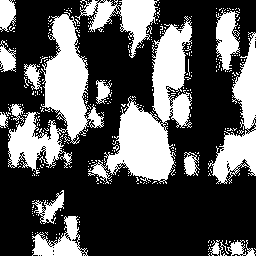

actual image


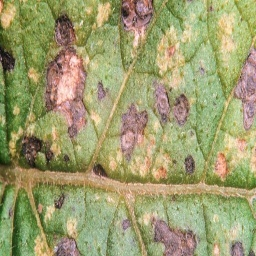

++++++++++++===========================++++++++++++++


In [ ]:
sample_test_images(unet_model)

## SGD


In [ ]:
unet_model = UNet(3,1,optim.SGD,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:18<00:00,  2.76s/it]


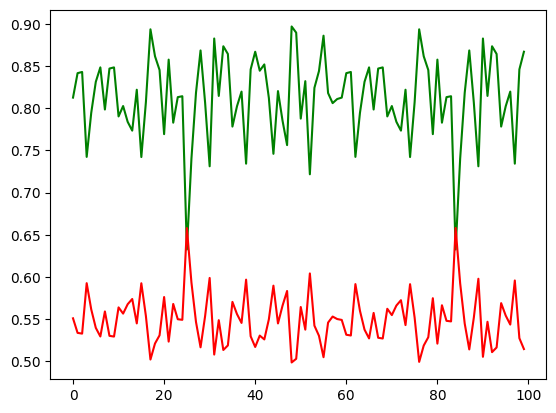

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 144.43it/s]


training
loss 18.687776606133642
accuracy 0.8131222339386636
++++++++++++
test
loss 19.77466647907839
accuracy 0.8022533352092162


The SGD was not performing well and was not able to segment the images.

In [ ]:
sample_test_images(unet_model)

## SGD with momuntum

In [ ]:
unet_model = UNet(3,1,optim.SGD,nn.BCELoss(),0.001,momuntum=0.9)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


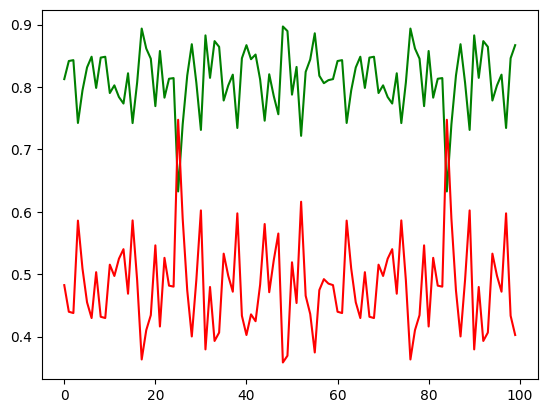

In [ ]:
plot_acc_and_loss(accuracies,losses)

As shown in the graph above the SGD with momentum showed a result that is close to the one without momentum. What made this one different is that the movements in the graph tend to be a bit further and more unstable.


In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 155.98it/s]


training
loss 18.687776606133642
accuracy 0.8131222339386636
++++++++++++
test
loss 19.77466647907839
accuracy 0.8022533352092162


In [ ]:
sample_test_images(unet_model)

# losses

## Binary cross entropy

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


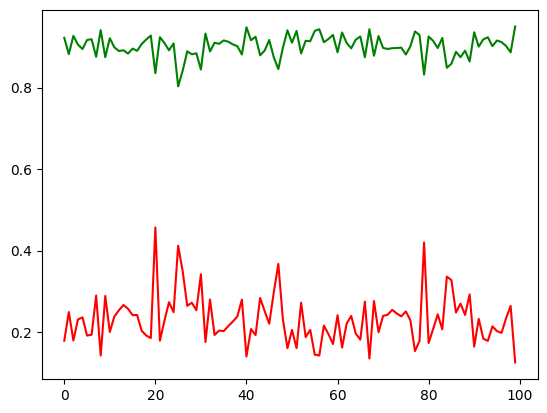

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 120.41it/s]


training
loss 9.32339607401097
accuracy 0.9067660392598903
++++++++++++
test
loss 12.401968745862023
accuracy 0.8759803125413798


The values obtained in the BCE loss were a lot better than those obtained by using the mean squared error.

+++++++++++++=========================++++++++++++++
predicted image


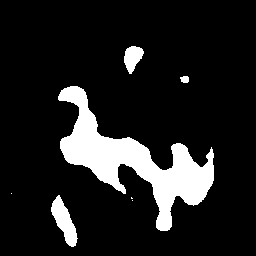

true label


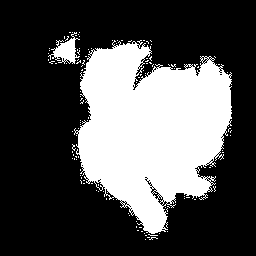

actual image


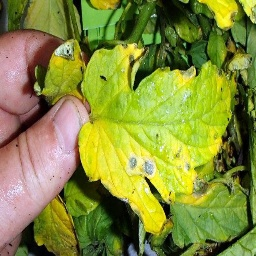

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


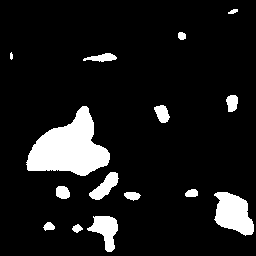

true label


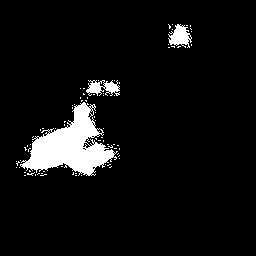

actual image


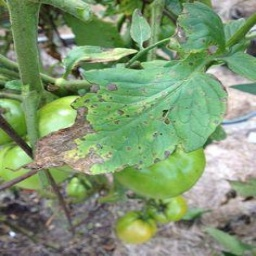

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


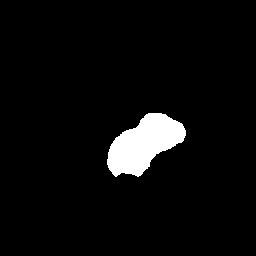

true label


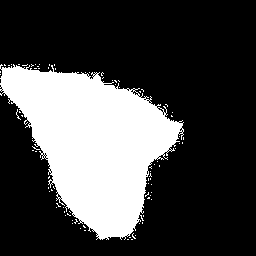

actual image


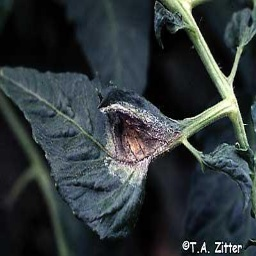

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


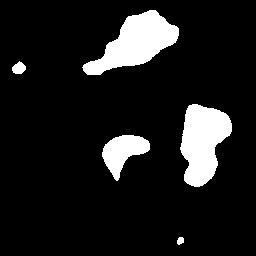

true label


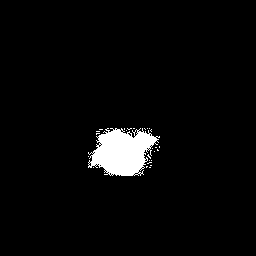

actual image


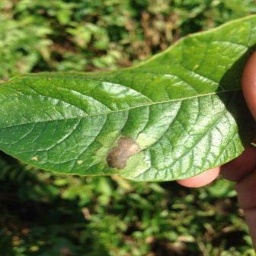

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


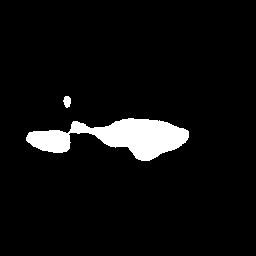

true label


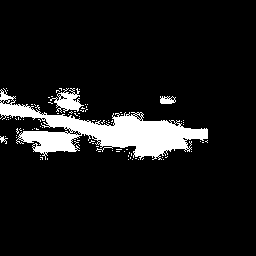

actual image


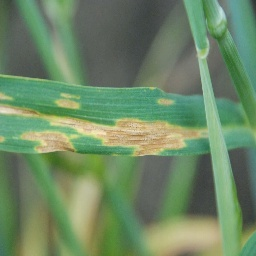

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


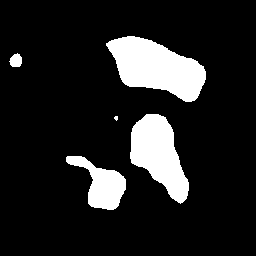

true label


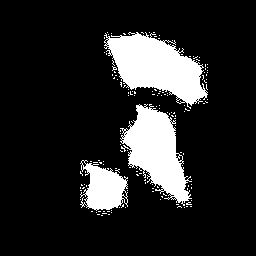

actual image


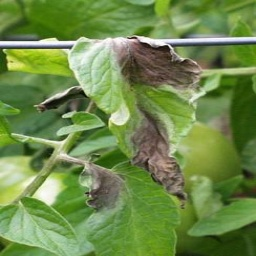

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


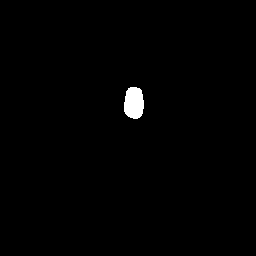

true label


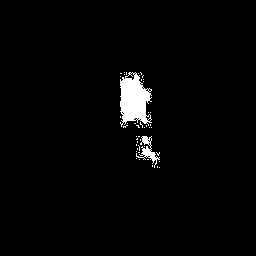

actual image


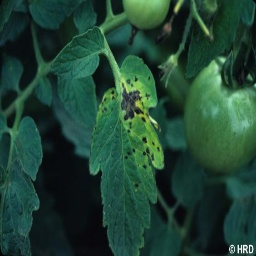

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


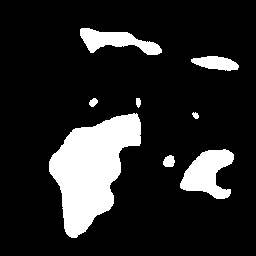

true label


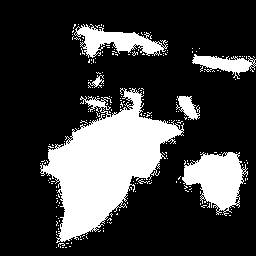

actual image


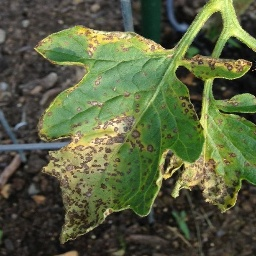

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


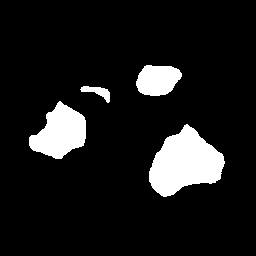

true label


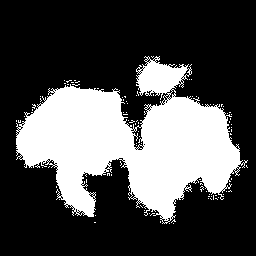

actual image


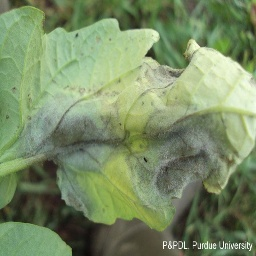

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


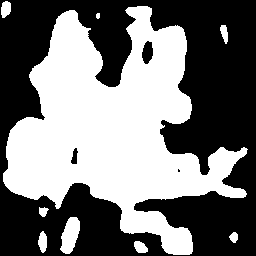

true label


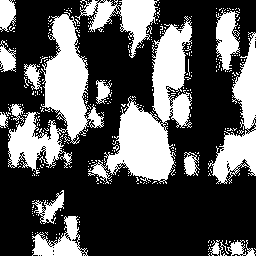

actual image


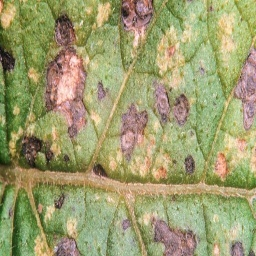

++++++++++++===========================++++++++++++++


In [ ]:
sample_test_images(unet_model)

## Mean squared error

In [ ]:
unet_model = UNet(3,1,optim.SGD,nn.MSELoss(),0.001,momuntum=0.9)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


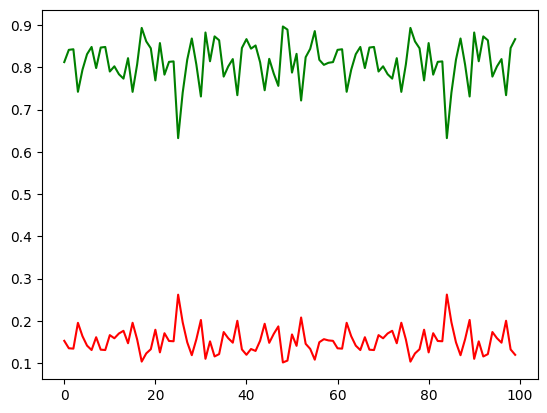

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 146.21it/s]


training
loss 18.687776606133642
accuracy 0.8131222339386636
++++++++++++
test
loss 19.77466647907839
accuracy 0.8022533352092162


The model was not able to converge well and kept returning values that are less than 0.5 for the whole image.

In [ ]:
sample_test_images(unet_model)

# batch sizes

## batch size of 1

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(1,50,x_train,y_train)

100%|██████████| 50/50 [04:39<00:00,  5.59s/it]


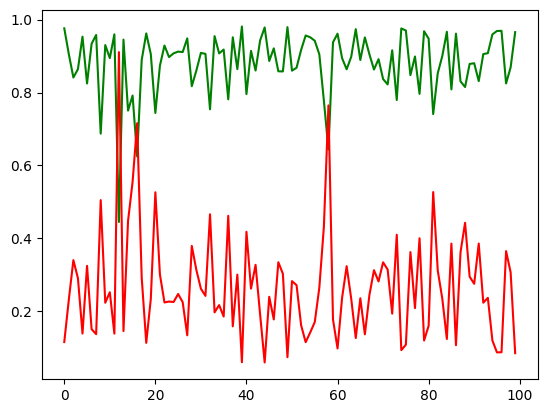

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 155.43it/s]


training
loss 11.152622953374335
accuracy 0.8884737704662566
++++++++++++
test
loss 13.307797706733316
accuracy 0.8669220229326668


Even though the numbers seemed a bit good the training process with a single instance per batch was highly unstable as shown in the graph above with a high amount of fluctuation in the accuracy and the loss values.

In [ ]:
sample_test_images(unet_model)

## batch size of 8

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(8,50,x_train,y_train)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


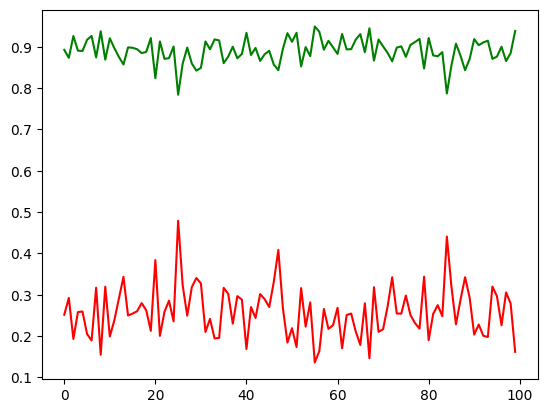

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 162.82it/s]


training
loss 10.723691899725731
accuracy 0.8927630810027427
++++++++++++
test
loss 13.044312040684586
accuracy 0.8695568795931541


The batch size of eight showed better training accuracy even though the test results were close. It also had better stability than the previous one.

In [ ]:
sample_test_images(unet_model)

## batch size of 16

In [58]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(16,50,x_train,y_train)

100%|██████████| 50/50 [02:09<00:00,  2.60s/it]


In [59]:
torch.save(unet_model.model.state_dict(), 'model.pth')

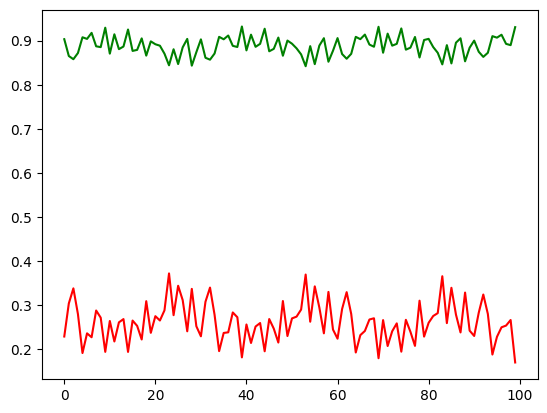

In [60]:
plot_acc_and_loss(accuracies,losses)

In [61]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 132.61it/s]


training
loss 11.716022897273936
accuracy 0.8828397710272606
++++++++++++
test
loss 12.719765356031514
accuracy 0.8728023464396849


This one showed better performance than both and also showed good stability in training.


+++++++++++++=========================++++++++++++++
predicted image


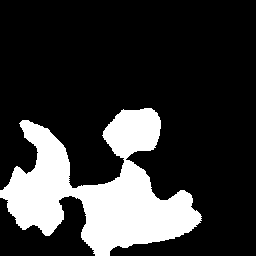

true label


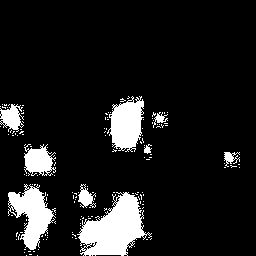

actual image


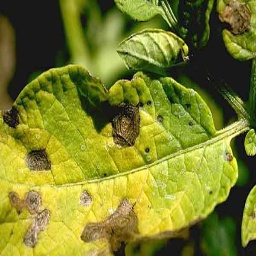

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


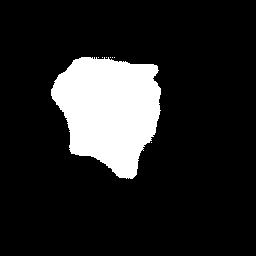

true label


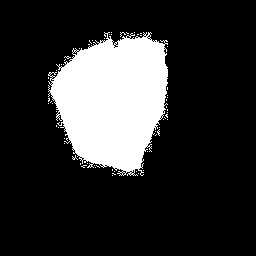

actual image


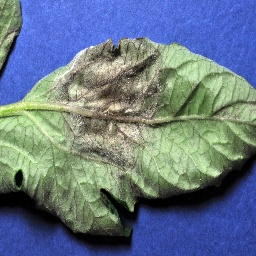

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


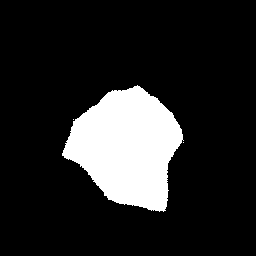

true label


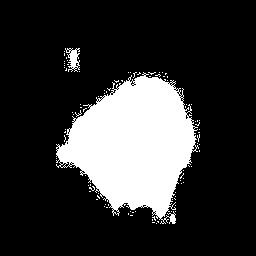

actual image


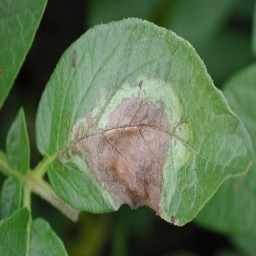

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


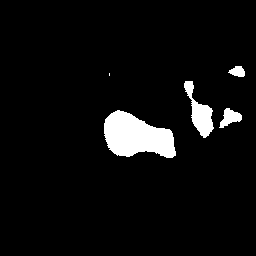

true label


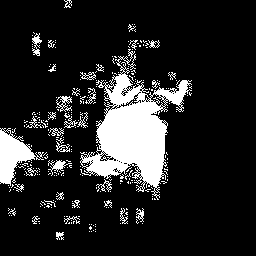

actual image


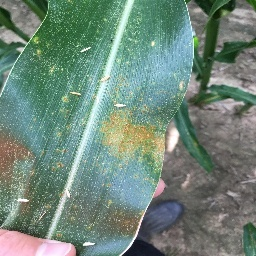

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


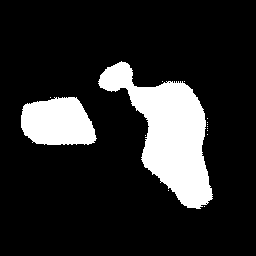

true label


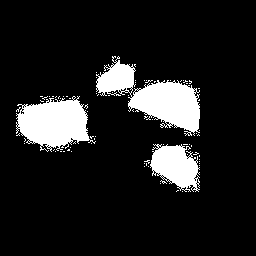

actual image


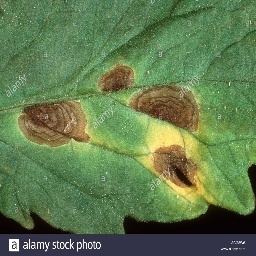

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


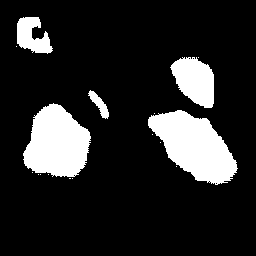

true label


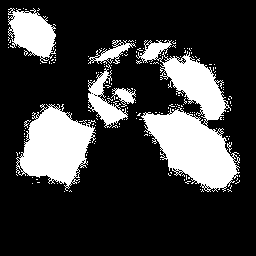

actual image


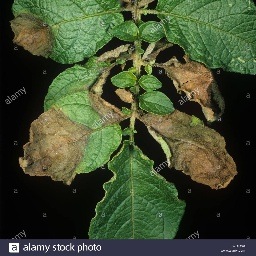

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


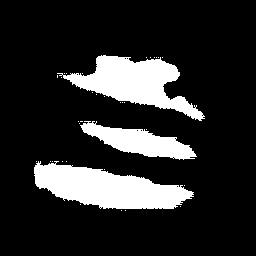

true label


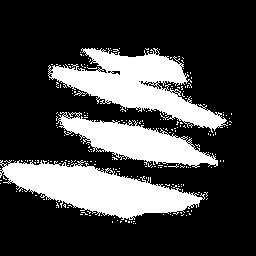

actual image


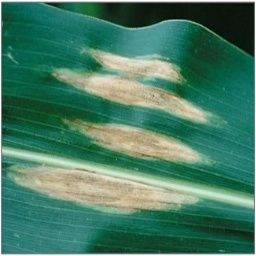

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


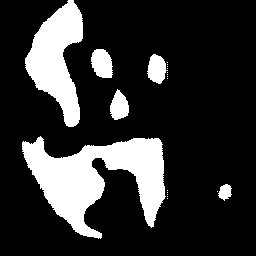

true label


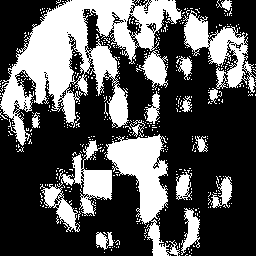

actual image


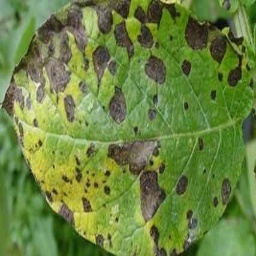

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


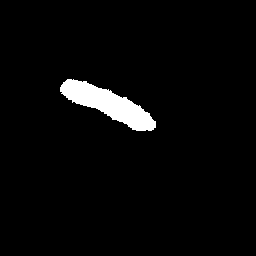

true label


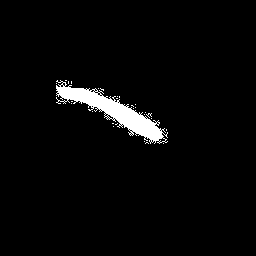

actual image


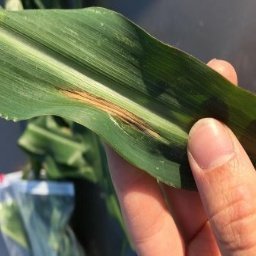

++++++++++++===========================++++++++++++++
+++++++++++++=========================++++++++++++++
predicted image


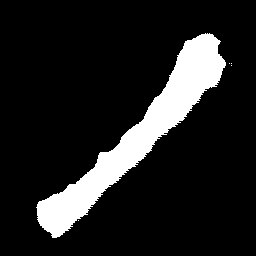

true label


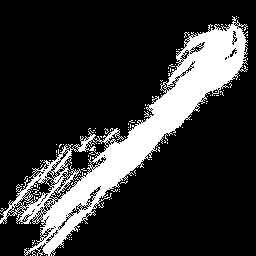

actual image


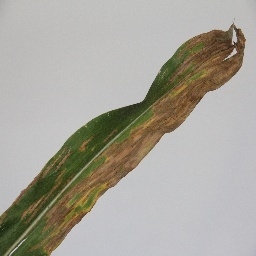

++++++++++++===========================++++++++++++++


In [62]:
sample_test_images(unet_model)

## batch size of 32

In [ ]:
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
losses,accuracies = unet_model.fit(32,50,x_train,y_train)

100%|██████████| 50/50 [02:20<00:00,  2.81s/it]


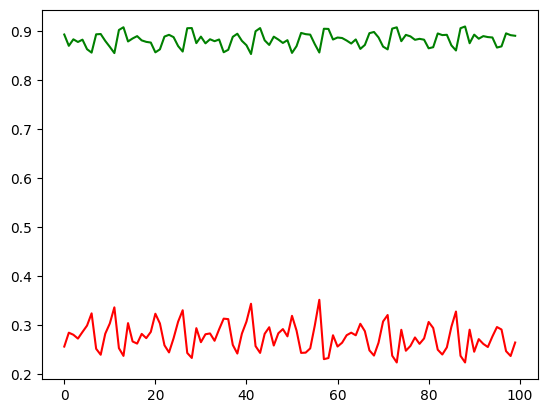

In [ ]:
plot_acc_and_loss(accuracies,losses)

In [ ]:
training_and_testing_accuracy(unet_model)

100%|██████████| 118/118 [00:00<00:00, 170.69it/s]


training
loss 11.678122662483378
accuracy 0.8832187733751662
++++++++++++
test
loss 13.632163354905986
accuracy 0.8636783664509401


Even though the accuracy was less than that of the one with 16 sized batches it was better in accuracy than the ones with 1 and 8 sized batches it also had a lot more stability that all the models.


In [ ]:
sample_test_images(unet_model)

## batch size versus accuracy

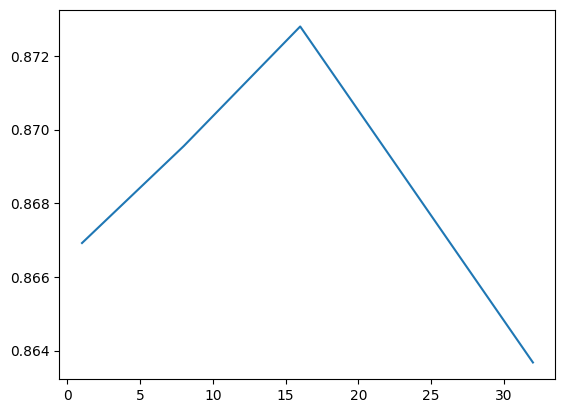

In [63]:
batch = [1,8,16,32]
accuracies = [0.8669220229326668,0.8695568795931541,0.8728023464396849,0.8636783664509401]
plt.plot(batch,accuracies)

## batch versus loss

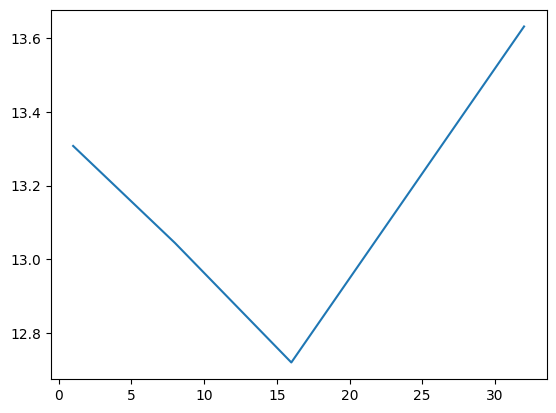

In [64]:
batch = [1,8,16,32]
loss = [13.307797706733316,13.044312040684586,12.719765356031514,13.632163354905986]
plt.plot(batch,loss)

# Conclusion

+ In terms of learning rates smaller ones were better also as they decrease a lot the accuracy also tend to decrease a little bit
+ In terms of optimizers Adam was found to be more fit than the other optimization algorithms.
+ In terms of loss Binary Cross Entropy tend to do better job than the other loss function for this task
+ In terms of batch sizes as the batch sizes increase the stability of the training process increases but after a while the accuracy tends to decrease and 16 was the best batch size in terms of accuracy and loss.


# loading the model and testing

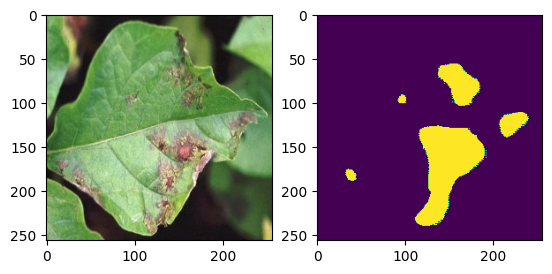

In [65]:
#####use your image path here
path_to_image = "drive/MyDrive/leaf data/preprocessed/images/100.jpg"
########################
unet_model = UNet(3,1,optim.Adam,nn.BCELoss(),0.001)
unet_model.model.load_state_dict(torch.load('model.pth'))
img = cv.imread(path_to_image)
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
img = torch.Tensor(np.transpose(img, (2, 0, 1)))
pred = unet_model.forward(img)
pred = pred.cpu().detach().numpy()
pred = (np.transpose(pred, (1, 2, 0))>=0.5).astype(float)
plt.subplot(1,2,2)
plt.imshow(pred)